In [1]:
import clickhouse_connect
import pandas as pd
import matplotlib.pyplot as plt

USER = "default"
PASSWORD = "password"

# Первый вариант - загрузка из CSV
# df= pd.read_csv("./csv/BRG4_15-01-2024.csv", names=['NO', 'TRADENO', 'DATE', 'TIME', 'SECID', 'PRICE', 'QUANTITY', 'OPERATION', 'OI'])
# Второй вариант - загрузка из Clickhouse
client = clickhouse_connect.get_client(host="localhost", port="8123", user=USER, password=PASSWORD)
df = pd.DataFrame(
    client.query("SELECT ID_DTTM, OPERATION, PRICE, QUANTITY, OI FROM moex.br_trades bt where bt.ID_DTTM>toDateTime('2024-01-16 08:50:00') and bt.ID_DTTM<toDateTime('2024-01-17 00:00:00') order by bt.ID_DTTM").result_rows,
    columns = ['ID_DTTM', 'OPERATION', 'PRICE', 'QUANTITY', 'OI']
)
df.head(3)





,ID_DTTM,OPERATION,PRICE,QUANTITY,OI
0,2024-01-16 08:59:26+05:00,S,78.400002,18,459674
1,2024-01-16 08:59:26+05:00,B,78.400002,1,459674
2,2024-01-16 08:59:26+05:00,S,78.400002,5,459674


In [2]:
df.describe()

,PRICE,QUANTITY,OI
count,105239.000000,105239.000000,105239.000000
mean,78.758818,4.591492,453314.751946
std,0.354479,10.668257,7768.850432
min,78.010002,1.000000,441026.000000
25%,78.449997,1.000000,446920.000000
50%,78.769997,2.000000,452110.000000
75%,79.019997,4.000000,460422.000000
max,79.580002,500.000000,469404.000000


<Figure size 640x480 with 0 Axes>

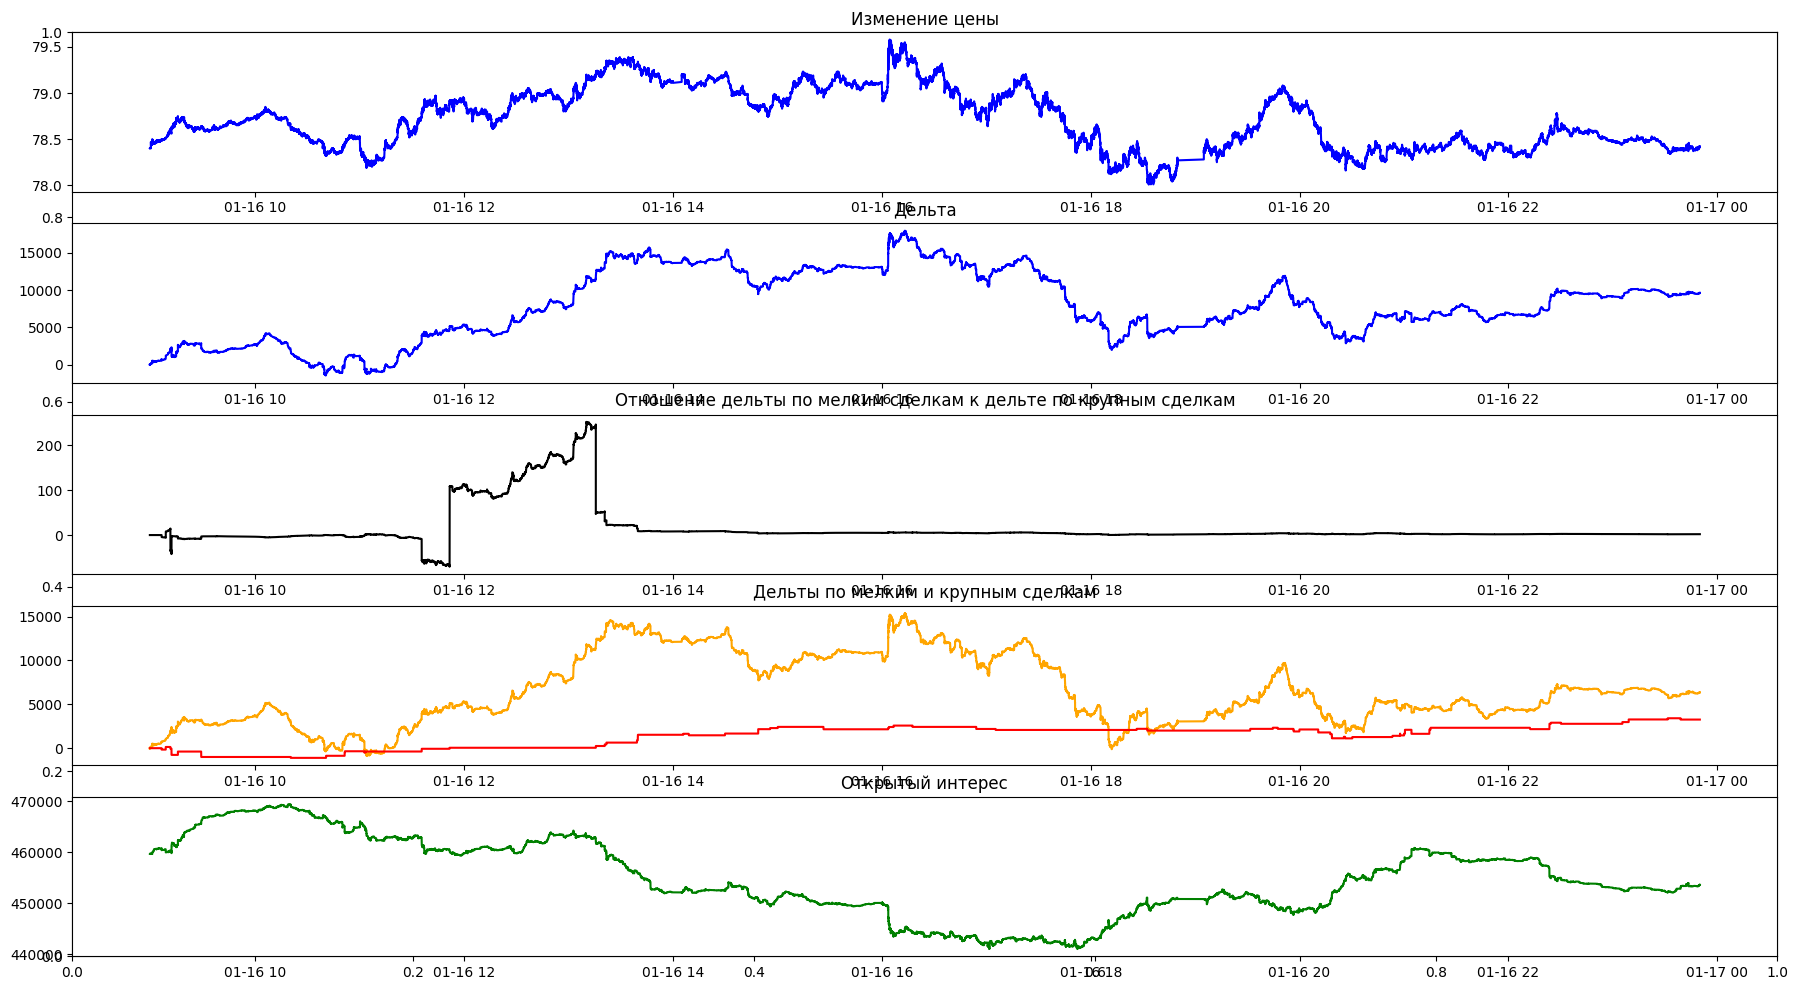

In [10]:
delta = 0
small_delta = 0
big_delta = 0
big_quantity = 100
delta_diff = 0
delta_list = []
small_delta_list = []
big_delta_list = []
delta_diff_list = []

for col,row in df.iterrows():
    if row['OPERATION']=='B':
        delta = delta + int(row['QUANTITY'])
        if int(row['QUANTITY'])>big_quantity:
            big_delta = big_delta + int(row['QUANTITY'])
        else:
            small_delta = small_delta + int(row['QUANTITY'])
    else:
        delta = delta - int(row['QUANTITY'])
        if int(row['QUANTITY'])>big_quantity:
            big_delta = big_delta - int(row['QUANTITY'])
        else:
            small_delta = small_delta - int(row['QUANTITY'])    
    # row['D_COMMON']=delta
    delta_list.append(delta)
    big_delta_list.append(big_delta)
    small_delta_list.append(small_delta)
    if (small_delta!=0) and (big_delta!=0):
        delta_diff = small_delta / big_delta
    else:
        delta_diff = 0
    delta_diff_list.append(delta_diff)    
df['D_COMMON'] = delta_list
df['D_SMALL'] = small_delta_list
df['D_BIG'] = big_delta_list
df['D_DIFF'] = delta_diff_list

plt.figure()
plt.subplots(figsize=(22, 12))
plt.subplot(511)
plt.plot(df['ID_DTTM'], df['PRICE'], color='blue')
plt.title('Изменение цены')

plt.subplot(512)
plt.plot(df['ID_DTTM'], df['D_COMMON'], color='blue')
plt.title('Дельта')

plt.subplot(513)
plt.plot(df['ID_DTTM'], df['D_DIFF'], color='black')
plt.title('Отношение дельты по мелким сделкам к дельте по крупным сделкам')

plt.subplot(514)
plt.plot(df['ID_DTTM'], df['D_SMALL'], color='orange')
plt.plot(df['ID_DTTM'], df['D_BIG'], color='red')
plt.title('Дельты по мелким и крупным сделкам')

plt.subplot(515)
plt.plot(df['ID_DTTM'], df['OI'], color='green')
plt.title('Открытый интерес')

plt.show()